# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import glob
from matplotlib.dates import drange
import matplotlib.dates as mdates
import os
import random

In [2]:
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.utils import shuffle
import copy
from torch.cuda import amp
from IPython.display import clear_output

# Configs

In [3]:
class cfg:
    local = False

    predict_test = True
    include_val_splits = [4,3,2,1,0] # to includa these val splits to train, (only done if predict_test==True)
    
    num_splits = 5
    val_splits = [0,1,2,3] if predict_test else [0,1]
    
    use_sample_val = False

    seed = 101

    use_gpu = True
    device = torch.device("cuda:0" if use_gpu else "cpu")
    
    load_weights = False

In [4]:
if not torch.cuda.is_available() and cfg.use_gpu == True:
    assert False, 'GPU is not available'

In [5]:
def set_seed(seed = 42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # cudf.cupy.random.seed(seed)

    print('Setting seed done')
    
set_seed(cfg.seed)

Setting seed done


In [ ]:
if cfg.local:
    save_dir = '../../data/models'
else:
    save_dir = '/kaggle/working'

file_paths_save = {
    'best_model_epoch': f'{save_dir}/torch_model_best_epoch_wts_1.bin',
    'last_model_epoch': f'{save_dir}/torch_model_last_epoch_wts_1.bin',
}

In [7]:
if cfg.local:
    data_dir = '../../data/original_data_updated'
    prepared_data_dir = '../../data/prepared_data'
else:
    data_dir = '/kaggle/input/godaddy-microbusiness-density-forecasting'
    prepared_data_dir = '/kaggle/input/microbusiness-prepare-data-active-1/prepared_data'

file_paths = {
    'train': f'{data_dir}/train.csv',
    'test': f'{data_dir}/test.csv',
    'census_starter': f'{data_dir}/census_starter.csv',
    'sample_submission': f'{data_dir}/sample_submission.csv',

    'train_splits': glob.glob(f'{prepared_data_dir}/train/train_*.parquet'),
    'val_splits': glob.glob(f'{prepared_data_dir}/val/val_*.parquet'),
    
    'weights_path': '/kaggle/input/microbusiness-model-3-active/cpu_kaggle_model_4_2023-03-12.bin'
}

file_paths['train_splits'].sort()
file_paths['val_splits'].sort()
file_paths

{'train': '/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv',
 'test': '/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv',
 'census_starter': '/kaggle/input/godaddy-microbusiness-density-forecasting/census_starter.csv',
 'sample_submission': '/kaggle/input/godaddy-microbusiness-density-forecasting/sample_submission.csv',
 'train_splits': ['/kaggle/input/microbusiness-prepare-data-active-1/prepared_data/train/train_0.parquet',
  '/kaggle/input/microbusiness-prepare-data-active-1/prepared_data/train/train_1.parquet',
  '/kaggle/input/microbusiness-prepare-data-active-1/prepared_data/train/train_2.parquet',
  '/kaggle/input/microbusiness-prepare-data-active-1/prepared_data/train/train_3.parquet',
  '/kaggle/input/microbusiness-prepare-data-active-1/prepared_data/train/train_4.parquet'],
 'val_splits': ['/kaggle/input/microbusiness-prepare-data-active-1/prepared_data/val/val_0.parquet',
  '/kaggle/input/microbusiness-prepare-data-active-1/prepared_data/val/

# Load

In [8]:
train_df = pd.DataFrame()
for split_num in range(cfg.num_splits):
    tmp = pd.read_parquet(file_paths['train_splits'][split_num])
    print('Train split', split_num)
    tmp['split'] = split_num+5
    train_df = pd.concat([train_df, tmp])

Train split 0
Train split 1
Train split 2
Train split 3
Train split 4


In [9]:
if cfg.predict_test:
    for split_num in cfg.include_val_splits:
        tmp = pd.read_parquet(file_paths['val_splits'][split_num])
        print('Val split', split_num)
        tmp['split'] = split_num
        train_df = pd.concat([train_df, tmp])

Val split 4
Val split 3
Val split 2
Val split 1
Val split 0


In [10]:
train_df.split.value_counts()

5    3135
6    3135
7    3135
8    3135
9    3135
4    3135
3    3135
2    3135
1    3135
0    3135
Name: split, dtype: int64

In [11]:
del train_df['split']

In [12]:
if cfg.use_sample_val:
    from sklearn.model_selection import train_test_split
    tmp1, tmp2 = train_test_split(train_df.cfips.unique(), test_size=0.2, random_state=cfg.seed)
    
    tmp1 = pd.merge(train_df, pd.DataFrame({'cfips': tmp1}), on='cfips')
    tmp2 = pd.merge(train_df, pd.DataFrame({'cfips': tmp2}), on='cfips')
    
    train_df = tmp1
    del tmp1
    val_df = tmp2
    del tmp2
    
    print('Split train and val by sampling cfips')
else:
    val_df = pd.DataFrame()
    for split_num in cfg.val_splits:
        tmp = pd.read_parquet(file_paths['val_splits'][split_num])
        print('Val split', split_num)
        val_df = pd.concat([val_df, tmp])

Val split 0
Val split 1
Val split 2
Val split 3


In [13]:
print(train_df.isna().any().sum())
print(val_df.isna().any().sum())

0
0


In [16]:
target_cols = [
    'active_4',
    'active_3',
    'active_2',
    'active_1',
    'active_0',
]

# Helpers

In [ ]:
def preview_df(df, num=1):
    print(f'{len(df):,}')
    display(df.head(num))

In [17]:
def plot_weights(model):
    plt.hist(model.fc1.weight.detach().numpy())
    plt.show()
# plot_weights(model)
def custom_SMAPE_loss(y_pred, y_true):
    return 200.0 * torch.mean(
        torch.abs(y_pred - y_true) 
        / (torch.abs(y_pred) + torch.abs(y_true) + 1e-6)
    )

In [18]:
def plot_history(history, hist_type='loss', epochs_from_end=-200):
    train_history = history[f'train_{hist_type}']
    val_history = history[f'val_{hist_type}']

    fig,ax = plt.subplots(1,3, figsize=(20,4))

    ax[0].plot(train_history, label=f'train {hist_type}')
    ax[0].plot(val_history, label=f'val {hist_type}')
    ax[0].legend()
    ax[0].grid()

    from_i = max(len(train_history)-epochs_from_end,0)
    val_history_from = val_history[from_i:]
    train_history_from = train_history[from_i:]

    top_train = np.max(train_history_from)+1.0
    bottom_train = np.min(train_history_from)-1.0
    ax[1].plot(train_history, label=f'train {hist_type}')
    ax[1].set_ylim(bottom_train, top_train)
    ax[1].legend()
    ax[1].grid()

    top = np.max(val_history_from)+0.1
    bottom = np.min(val_history_from)-0.1
    ax[2].plot(val_history, label=f'val {hist_type}')
    ax[2].set_ylim(bottom, top)
    ax[2].legend()
    ax[2].grid()

    plt.show()

In [19]:
def plot_preds(preds, true_df, cfips_li=[1001, 1003, 1005, 1007]):
    preds_df = pd.DataFrame(preds)
    preds_df.columns = [c+'_pred' for c in target_cols]
    preds_df['cfips'] = true_df['cfips'].copy()
    preds_df = preds_df.melt(id_vars='cfips', var_name='months_distance', value_name='active')
    # display(preds_df)
    preds_df.months_distance = preds_df.months_distance.apply(lambda x: int(x.split('_')[1]))
    preds_df = preds_df.sort_values('months_distance', ascending=True)

    cols = [c for c in true_df.columns if 'active_' in c]
    cols.append('cfips')
    tmp = true_df[cols].copy()
    tmp = tmp.melt(id_vars='cfips', var_name='months_distance', value_name='active')
    tmp.months_distance = tmp.months_distance.apply(lambda x: int(x.split('_')[1]))
    tmp = tmp.sort_values('months_distance', ascending=True)

    preds_df = pd.concat([preds_df, tmp.loc[tmp.months_distance > 4]], axis=0)

    figure, axis = plt.subplots(1, 4, figsize=(20,4), squeeze=True)
    for i,one_cfips in enumerate(cfips_li):
        ax = axis[i%4]
        ax.plot(tmp.loc[tmp.cfips==one_cfips].months_distance, tmp.loc[tmp.cfips==one_cfips].active, 'b-')
        ax.plot(preds_df.loc[preds_df.cfips==one_cfips].months_distance, preds_df.loc[preds_df.cfips==one_cfips].active, 'r-')
        ax.set_title(one_cfips)
        ax.invert_xaxis()
        ax.grid()
    plt.show()

In [20]:
def get_preds_df(preds, true_df, months=[0,1,2,3,4]):

    pred_cols = [c+'_pred' for c in target_cols]
    tmp = pd.DataFrame(preds)
    tmp.columns = pred_cols

    preds_df = true_df[['cfips'] + target_cols]
    preds_df = pd.concat([preds_df, tmp], axis=1)
    return preds_df

def calc_smape(preds, true_df, months=[0,1,2,3,4]):
    pred_cols = [c+'_pred' for c in target_cols]
    tmp = pd.DataFrame(preds)
    tmp.columns = pred_cols

    preds_df = true_df[['cfips'] + target_cols]
    preds_df = pd.concat([preds_df, tmp], axis=1)
    # display(preds_df)

    return symmetric_mean_abs_prec_err(preds_df, months)
def symmetric_mean_abs_prec_err(preds_df, months=[0,1,2,3,4]):
    smape = np.zeros(len(months))
    for i, m in enumerate(months):
        smape[i] = 100.0 * np.mean(
            2.0
            * np.abs(preds_df[f'active_{m}'] - preds_df[f'active_{m}_pred']) 
            / (np.abs(preds_df[f'active_{m}']) + np.abs(preds_df[f'active_{m}_pred']))
        )

    return np.mean(smape)
def smape(preds_npy, true_npy):
    return 100.0 * np.mean(
        2.0
        * np.abs(preds_npy - true_npy) 
        / (np.abs(preds_npy) + np.abs(true_npy))
    )

def smape_torch(preds_tensor, true_tensor):
    return 100.0 * torch.mean(
        2.0
        * torch.abs(preds_tensor - true_tensor) 
        / (torch.abs(preds_tensor) + torch.abs(true_tensor) + 1e-9)
    )

In [21]:
def format_num(x):
    dec_points = 4
    total_chars_taken = 8
    # total_chars_in_str = 8
    return f'{str(round(x, dec_points))[:total_chars_taken]:8}'
# format_num(1.234524)

# Train

In [22]:
feature_cols = [

    'active_5', 'active_6', 'active_7', 'active_8', 'active_9', 'active_10', 'active_11', 'active_12',

    'county_code', 
    'state_code',

    'mean_12', 'median_12', 'mean_med_diff_12', 
    'min_12', 'max_12', 

    'last_1_diff', 'last_2_diff', 'last_3_diff', 'last_4_diff', 
    'last_5_diff', 'last_6_diff', 'last_7_diff', 'last_8_diff', 
    'last_9_diff', 'last_10_diff', 'last_11_diff', 'last_12_diff',

    'max_diff_12', 'min_diff_12', 'median_diff_12', 'mean_diff_12', 

    'last_1_diff_perc', 'last_2_diff_perc', 'last_3_diff_perc', 'last_4_diff_perc', 
    'last_5_diff_perc', 'last_6_diff_perc', 'last_7_diff_perc', 'last_8_diff_perc', 
    'last_9_diff_perc', 'last_10_diff_perc', 'last_11_diff_perc', 'last_12_diff_perc',

    'max_diff_perc_12', 'min_diff_perc_12', 'median_diff_perc_12', 'mean_diff_perc_12', 
    
    'population_range', 'population_change', 
    
    'lng', 'lat',

    'DIVISION',
]

In [23]:
# print([col for col in list(train_df.columns) if 'bs' in col])

In [24]:
train_df

,cfips,mb_density_0,mb_density_1,mb_density_2,mb_density_3,mb_density_4,mb_density_5,mb_density_6,mb_density_7,mb_density_8,...,INTERNATIONALMIG_diff_perc_2020,INTERNATIONALMIG_diff_perc_2021,DOMESTICMIG_diff_perc_2020,DOMESTICMIG_diff_perc_2021,NETMIG_diff_perc_2020,NETMIG_diff_perc_2021,RESIDUAL_diff_perc_2020,RESIDUAL_diff_perc_2021,GQESTIMATES_diff_perc_2020,GQESTIMATES_diff_perc_2021
0,1001,3.437971,3.346197,3.313253,3.372082,3.336785,3.334431,3.296781,3.286307,3.200948,...,10.000000,-1.000000,1.443299,-0.590717,1.494845,-0.599174,1.000000e+01,-1.000000e+00,-2.262444e-09,-2.262444e-09
1,1003,8.573463,8.507496,7.907365,7.979170,7.945311,7.823300,7.733397,7.930010,7.900597,...,-10.000000,-1.015873,3.472296,-0.776401,3.516832,-0.778606,9.250001e+00,-9.024390e-01,-4.593477e-10,-4.593477e-10
2,1005,1.216926,1.191678,1.186629,1.191678,1.196728,1.206827,1.186629,1.151890,1.151890,...,10.000000,-1.000000,-10.000000,-1.030612,-10.000000,-1.030928,-2.000001e+00,-1.999999e+00,-3.585514e-10,-3.585514e-10
3,1007,1.326588,1.275998,1.247892,1.253513,1.264755,1.236650,1.214165,1.209271,1.231665,...,10.000000,-1.000000,-8.357143,-1.135922,-8.404762,-1.135048,-1.000000e+01,-1.000000e+00,-4.849660e-10,-4.849660e-10
4,1009,1.831782,1.773201,1.748417,1.764189,1.797986,1.777708,1.752923,1.752009,1.733947,...,10.000000,-1.000000,7.235294,-0.878571,7.352941,-0.880282,-5.500002e+00,-1.222222e+00,-2.227171e-09,-2.227171e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3130,56037,2.876845,2.814440,2.823801,2.811320,2.811320,2.836282,2.783238,2.820681,2.851883,...,10.000000,-0.944444,4.654867,-0.823161,4.544643,-0.819646,-2.999999e+00,-1.500000e+00,-1.388889e-09,-1.388889e-09
3131,56039,26.314966,26.372364,26.273220,26.090586,26.085369,25.939260,25.652266,25.506157,25.626175,...,2.999998,-0.750000,-10.000000,-1.021053,10.000000,-1.000000,-9.999990e-07,-9.999990e-07,-4.651163e-09,-4.651163e-09
3132,56041,4.050703,4.016258,4.009369,3.995591,3.974924,3.981813,3.906035,3.885368,4.064481,...,10.000000,-1.000000,-10.000000,-1.083969,-10.000000,-1.082090,-1.000000e+00,1.000000e+01,-5.347593e-09,-5.347593e-09
3133,56043,3.060380,3.143093,3.126551,3.209264,3.209264,3.225806,3.126551,2.944582,2.977668,...,-1.000000,-1.000000,-7.692308,-1.149425,-7.692308,-1.149425,-1.000000e+01,-1.000000e+00,-8.403362e-09,-8.403362e-09


In [26]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(len(feature_cols), 512, bias=False)
        self.fc2 = nn.Linear(512, 128, bias=False)
#         self.dr2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(128, 18, bias=False)
        # self.dr3 = nn.Dropout(0.1)
        self.fc4 = nn.Linear(18, len(target_cols), bias=False)
        # self.dr4 = nn.Dropout(0.1)

        self.af1 = nn.ELU()
        self.af2 = nn.LeakyReLU()
        self.af3 = nn.LeakyReLU()
        self.af4 = nn.LeakyReLU()


    def forward(self, inputs):
        x = inputs

        x = self.fc1(x)
        x = self.af1(x)

        x = self.fc2(x)
#         x = self.dr2(x)
        x = self.af2(x)

        x = self.fc3(x)
        # x = self.dr3(x)
        x = self.af3(x)
        
        x = self.fc4(x)
        x = self.af4(x)

        return x

In [27]:
# train_df = train_df.loc[train_df.population_range == 0]
# val_df = val_df.loc[val_df.population_range == 0]

In [28]:
train_df = train_df.sample(len(train_df)).reset_index(drop=True)
val_df = val_df.sample(len(val_df)).reset_index(drop=True)

x_train = train_df[feature_cols]
y_train = train_df[target_cols]

x_val = val_df[feature_cols]
y_val = val_df[target_cols]

In [29]:
x_train_np = x_train.values
y_train_np = y_train.values

x_val_np = x_val.values
y_val_np = y_val.values

In [30]:
print(x_train_np.shape, y_train_np.shape)
print(x_val_np.shape, y_val_np.shape)

print(np.isnan(x_train_np).any(), np.isnan(y_train_np).any())
print(np.isnan(x_val_np).any(), np.isnan(y_val_np).any())

(31350, 52) (31350, 5)
(12540, 52) (12540, 5)
False False
False False


In [31]:
x_train_tensor = torch.tensor(x_train_np, device=cfg.device, dtype=torch.float32, requires_grad=True)
y_train_tensor = torch.tensor(y_train_np, device=cfg.device, dtype=torch.float32, requires_grad=True)

x_val_tensor = torch.tensor(x_val_np, device=cfg.device, dtype=torch.float32, requires_grad=False)
y_val_tensor = torch.tensor(y_val_np, device=cfg.device, dtype=torch.float32, requires_grad=False)

In [33]:
def init_model_weights(model):
    _ = torch.nn.init.normal_(model.fc1.weight, mean=0.0, std=0.01)
    _ = torch.nn.init.normal_(model.fc2.weight, mean=0.0, std=0.01)
    _ = torch.nn.init.normal_(model.fc3.weight, mean=0.0, std=0.01)
    _ = torch.nn.init.normal_(model.fc4.weight, mean=0.0, std=0.01)

    return model

In [34]:
model = Net()
model.to(cfg.device)

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
if cfg.predict_test:        
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 500, 10_000], gamma=0.1)
else:
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 500, 10_000], gamma=0.1)
scheduler2 = None

model = init_model_weights(model)
model.eval()

print(sum(p.numel() for p in model.parameters()))

94554


In [35]:
if cfg.load_weights:
    model.load_state_dict(torch.load(file_paths['weights_path']))
    model.to(cfg.device)
    model.eval()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 60_000], gamma=0.1)
    
    print('Weights loaded')

### Run training

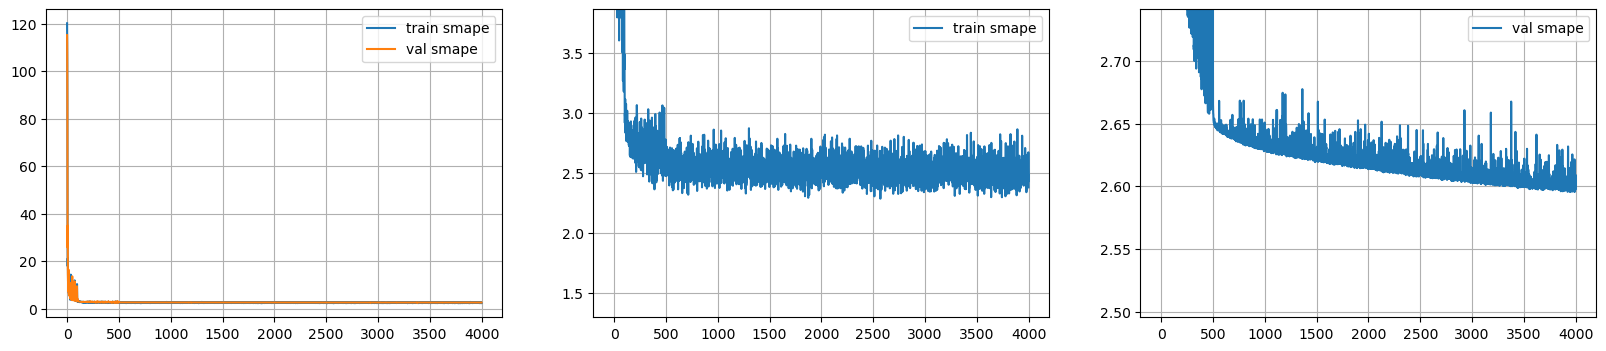

Best epoch: 3945 Loss: 2.59543 SMAPE: 2.59549


In [40]:
history = {'train_loss': [], 'val_loss': [], 'lr': [], 'train_smape': [], 'val_smape': []}

batch_size = 3135
print(len(x_train_np), len(x_train_np) / batch_size)
batch_num = len(x_train_np) // batch_size
best_val_loss = 1000
best_val_smape = 1000
num_epochs = 100_000
if cfg.predict_test:
    num_epochs = 4000

early_stopping_epochs = 2_000
best_epoch = 0
best_val_min_lr = 1.1e-5
print_best_weights = False
print_every = 100

_train_size = [batch_size, len(feature_cols)]
_val_size = [batch_size, len(target_cols)]
changed_batch_size = False

print('num_epochs', num_epochs)
print('batch_num', batch_num)
print('batch_size', batch_size)
print('early_stopping_epochs', early_stopping_epochs)
print('best_val_min_lr', best_val_min_lr)
for epoch in range(num_epochs):
    idx = torch.randperm(x_train_tensor.size()[0])

    # Mini batch learning
    model.train()
    for i in range(batch_num):
        start = i * batch_size
        end = start + batch_size

        x_var = x_train_tensor[idx][start:end].view(_train_size)
        y_var = y_train_tensor[idx][start:end].view(_val_size)

        optimizer.zero_grad()
#         with amp.autocast(enabled=True):

        ypred_var = model(x_var)
#         train_loss = criterion(ypred_var, y_var)
        train_loss = custom_SMAPE_loss(ypred_var, y_var)

        train_loss.backward()
        optimizer.step()
        
    if scheduler is not None: scheduler.step()

    # This is last train loss in epoch, so losses of other batches are not marked, 
    train_loss_num = round(train_loss.item(), 5)
    history['train_loss'].append(train_loss_num)
    train_smape = smape_torch(ypred_var, y_var)
    train_smape_num = round(train_smape.item(), 5)
    history['train_smape'].append(train_smape_num)

    # Evaluate the model
    model.eval()
    x_val_var = x_val_tensor
    with torch.no_grad():
        val_preds = model(x_val_var)
    
    y_val_var = y_val_tensor
    val_loss = custom_SMAPE_loss(val_preds, y_val_var)
    val_loss_num = round(val_loss.item(), 5)

    history['val_loss'].append(val_loss_num)
    val_smape = smape_torch(val_preds, y_val_var)
    val_smape_num = round(val_smape.item(), 5)
    history['val_smape'].append(val_smape_num)
    if scheduler is not None:
        last_lr = scheduler.get_last_lr()[0]
    else:
        last_lr = optimizer.param_groups[0]['lr']
    history['lr'].append(last_lr)
    
    if scheduler2 is not None: scheduler2.step(val_smape)

    if last_lr <= best_val_min_lr and epoch > 1000:
        if val_smape_num < best_val_smape:
            best_train_smape = train_smape_num
            best_train_loss = train_loss_num
            best_val_smape = val_smape_num
            best_val_loss = val_loss_num
            best_epoch = epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            
            print_best_weights = True

    if epoch > (best_epoch + early_stopping_epochs) and best_epoch != 0:
        print('-'*30)
        print('Early stopping')
        print('End epoch:', epoch, end=' ')
        print('Loss:', train_loss_num, val_loss_num, 'SMAPE:', train_smape_num, val_smape_num)

        break
        

    if (epoch+1) % print_every == 0:
        lr = history['lr'][-1]
        print(f'Epoch {epoch+1:5}, lr {lr:8.1E}', end=' ')
        if len(history['train_loss']) > 0:
            print('Loss:', train_loss_num, val_loss_num, 'SMAPE:', train_smape_num, val_smape_num)
        else:
            print()

        if print_best_weights:
            print('Updated best wts:', best_epoch, end=' ')
            print('Loss:', best_train_loss, best_val_loss, 'SMAPE:', best_train_smape, best_val_smape)
            print_best_weights = False

    if (epoch+1) % (print_every * 10) == 0:
        clear_output(wait=True)
        plot_history(history, 'smape', epochs_from_end=(print_every * 5))

        
torch.save(model.state_dict(), file_paths_save['last_model_epoch'])

print('Best epoch:', best_epoch, 'Loss:', best_val_loss, 'SMAPE:', best_val_smape)
torch.save(best_model_wts, file_paths_save['best_model_epoch'])

In [44]:
model.load_state_dict(torch.load(file_paths_save['best_model_epoch']))

best_model_wts = copy.deepcopy(model.state_dict())
_time = datetime.datetime.now().date()
_path = f'./kaggle_model_4_{_time}.bin'
torch.save(model.state_dict(), _path)
print(_path)

./kaggle_model_4_2023-03-14.bin


## Run training 2

In [45]:
last_lr = optimizer.param_groups[0]['lr']
print(last_lr)

1e-05


In [46]:
optimizer = torch.optim.Adam(model.parameters(), lr=last_lr)
scheduler_milestones = [200]
scheduler_gamma = 0.1
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=scheduler_milestones, gamma=scheduler_gamma)

In [47]:
model.to(cfg.device)

Net(
  (fc1): Linear(in_features=52, out_features=512, bias=False)
  (fc2): Linear(in_features=512, out_features=128, bias=False)
  (fc3): Linear(in_features=128, out_features=18, bias=False)
  (fc4): Linear(in_features=18, out_features=5, bias=False)
  (af1): ELU(alpha=1.0)
  (af2): LeakyReLU(negative_slope=0.01)
  (af3): LeakyReLU(negative_slope=0.01)
  (af4): LeakyReLU(negative_slope=0.01)
)

In [48]:
# history = {'train_loss': [], 'val_loss': [], 'lr': [], 'train_smape': [], 'val_smape': []}

batch_size = 3135
print(len(x_train_np), len(x_train_np) / batch_size)

batch_num = len(x_train_np) // batch_size

best_val_loss = 1000
best_val_smape = 1000
num_epochs = 10_000
num_epochs = 400
if cfg.predict_test:
    num_epochs = 400
early_stopping_epochs = 1_000
best_epoch = 0
best_val_min_lr = 1.1 * last_lr * scheduler_gamma * len(scheduler_milestones)
print_best_weights = False
print_every = 100

_train_size = [batch_size, len(feature_cols)]
_val_size = [batch_size, len(target_cols)]
changed_batch_size = False

print('num_epochs', num_epochs)
print('batch_num', batch_num)
print('batch_size', batch_size)
print('early_stopping_epochs', early_stopping_epochs)
print('best_val_min_lr', best_val_min_lr)
for epoch in range(num_epochs):
    idx = torch.randperm(x_train_tensor.size()[0])

    # Mini batch learning
    model.train()
    for i in range(batch_num):
        start = i * batch_size
        end = start + batch_size

        x_var = x_train_tensor[idx][start:end].view(_train_size)
        y_var = y_train_tensor[idx][start:end].view(_val_size)

        optimizer.zero_grad()
#         with amp.autocast(enabled=True):

        ypred_var = model(x_var)
        train_loss = custom_SMAPE_loss(ypred_var, y_var)
        
        train_loss.backward()
        optimizer.step()
        
    if scheduler is not None: scheduler.step()

    # This is last train loss in epoch, so losses of other batches are not marked
    train_loss_num = round(train_loss.item(), 5)
    history['train_loss'].append(train_loss_num)
    train_smape = smape_torch(ypred_var, y_var)
    train_smape_num = round(train_smape.item(), 5)
    history['train_smape'].append(train_smape_num)

    # Evaluate the model
    model.eval()
    x_val_var = x_val_tensor
    with torch.no_grad():
        val_preds = model(x_val_var)
    
    y_val_var = y_val_tensor
    val_loss = custom_SMAPE_loss(val_preds, y_val_var)
    val_loss_num = round(val_loss.item(), 5)

    history['val_loss'].append(val_loss_num)
    val_smape = smape_torch(val_preds, y_val_var)
    val_smape_num = round(val_smape.item(), 5)
    history['val_smape'].append(val_smape_num)
    if scheduler is not None:
        last_lr = scheduler.get_last_lr()[0]
    else:
        last_lr = optimizer.param_groups[0]['lr']
    history['lr'].append(last_lr)
    
    if scheduler2 is not None: scheduler2.step(val_smape)

    if last_lr <= best_val_min_lr and epoch > 10:
        if val_smape_num < best_val_smape:
            best_train_smape = train_smape_num
            best_train_loss = train_loss_num
            best_val_smape = val_smape_num
            best_val_loss = val_loss_num
            best_epoch = epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            
            print_best_weights = True

    if epoch > (best_epoch + early_stopping_epochs) and best_epoch != 0:
        print('-'*30)
        print('Early stopping')
        print('End epoch:', epoch, end=' ')
        print('Loss:', train_loss_num, val_loss_num, 'SMAPE:', train_smape_num, val_smape_num)

        break
        

    if (epoch+1) % print_every == 0:
        lr = history['lr'][-1]
        print(f'Epoch {epoch+1:5}, lr {lr:8.1E}', end=' ')
        if len(history['train_loss']) > 0:
            print('Loss:', train_loss_num, val_loss_num, 'SMAPE:', train_smape_num, val_smape_num)
        else:
            print()

        if print_best_weights:
            print('Updated best wts:', best_epoch, end=' ')
            print('Loss:', best_train_loss, best_val_loss, 'SMAPE:', best_train_smape, best_val_smape)
            print_best_weights = False

    if (epoch+1) % (print_every * 5) == 0:
        clear_output(wait=True)
        plot_history(history, 'smape', epochs_from_end=(print_every * 5))

        
print('Last epoch:', epoch+1, 'Loss:', val_loss_num, 'SMAPE:', val_smape_num)
torch.save(model.state_dict(), file_paths_save['last_model_epoch'])

print('Best epoch:', best_epoch, 'Loss:', best_val_loss, 'SMAPE:', best_val_smape)
torch.save(best_model_wts, file_paths_save['best_model_epoch'])

31350 10.0
num_epochs 400
batch_num 10
batch_size 3135
early_stopping_epochs 1000
best_val_min_lr 1.1000000000000003e-06
Epoch   100, lr  1.0E-05 Loss: 2.61669 2.59727 SMAPE: 2.61675 2.59732
Epoch   200, lr  1.0E-06 Loss: 2.53007 2.59928 SMAPE: 2.53013 2.59934
Updated best wts: 199 Loss: 2.53007 2.59928 SMAPE: 2.53013 2.59934
Epoch   300, lr  1.0E-06 Loss: 2.38444 2.59377 SMAPE: 2.38445 2.59382
Updated best wts: 274 Loss: 2.42728 2.59336 SMAPE: 2.4273 2.59341
Epoch   400, lr  1.0E-06 Loss: 2.38244 2.5936 SMAPE: 2.38245 2.59366
Updated best wts: 359 Loss: 2.47437 2.59331 SMAPE: 2.47442 2.59336
Last epoch: 400 Loss: 2.5936 SMAPE: 2.59366
Best epoch: 359 Loss: 2.59331 SMAPE: 2.59336


In [51]:
print('Best epoch:', best_epoch, 'Loss:', best_val_loss, 'SMAPE:', best_val_smape)

Best epoch: 359 Loss: 2.59331 SMAPE: 2.59336


In [52]:
model.load_state_dict(torch.load(file_paths_save['best_model_epoch']))

<All keys matched successfully>

In [53]:
# model.to('cpu')
best_model_wts = copy.deepcopy(model.state_dict())
_time = datetime.datetime.now().date()
_path = f'./kaggle_model_4_{_time}.bin'
torch.save(model.state_dict(), _path)
print(_path)

./kaggle_model_4_2023-03-14.bin


In [54]:
# model.load_state_dict(torch.load('./tmp_model_8_2023-03-02T11:17.bin'))

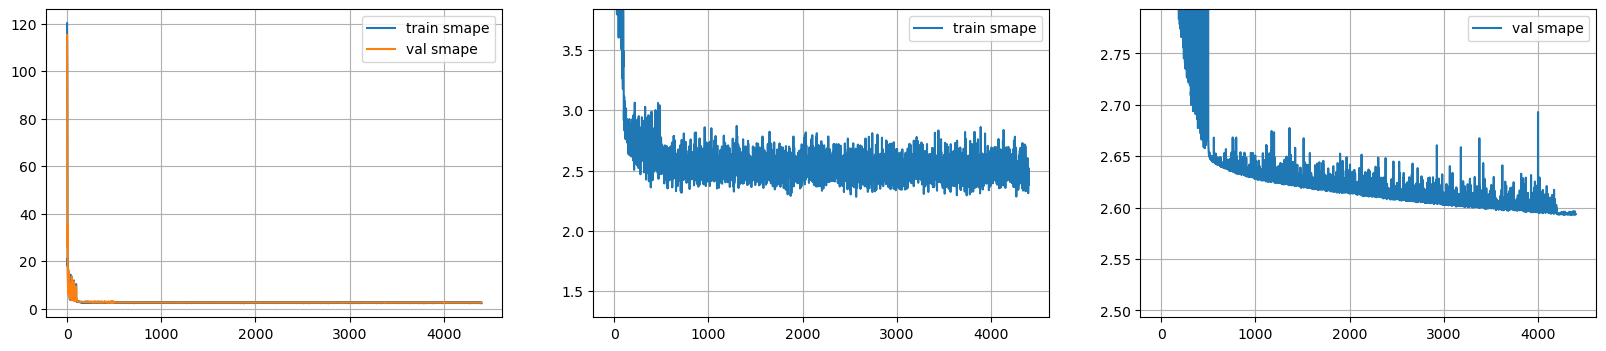

In [55]:
plot_history(history, 'smape', epochs_from_end=500)

# Eval

In [56]:
model.to('cpu')

Net(
  (fc1): Linear(in_features=52, out_features=512, bias=False)
  (fc2): Linear(in_features=512, out_features=128, bias=False)
  (fc3): Linear(in_features=128, out_features=18, bias=False)
  (fc4): Linear(in_features=18, out_features=5, bias=False)
  (af1): ELU(alpha=1.0)
  (af2): LeakyReLU(negative_slope=0.01)
  (af3): LeakyReLU(negative_slope=0.01)
  (af4): LeakyReLU(negative_slope=0.01)
)

In [57]:
best_model_wts = copy.deepcopy(model.state_dict())
_time = datetime.datetime.now().date()
_path = f'./cpu_kaggle_model_4_{_time}.bin'
torch.save(model.state_dict(), _path)
print(_path)

./cpu_kaggle_model_4_2023-03-14.bin


In [58]:
# Evaluate the model
model.eval()

for split in range(cfg.num_splits):
    print('Split', split, end=' | ')
    eval_train_df = pd.read_parquet(file_paths['train_splits'][split])
    eval_train_df = eval_train_df.sort_values(['cfips']).reset_index(drop=True)
    x_train_np = eval_train_df[feature_cols].to_numpy().reshape(len(eval_train_df), len(feature_cols))
    y_train_np = eval_train_df[target_cols].to_numpy().reshape(len(eval_train_df), len(target_cols))

    x_train_var = Variable(torch.FloatTensor(x_train_np), requires_grad=False)
    with torch.no_grad():
        train_preds = model(x_train_var)

    y_train_var = Variable(torch.FloatTensor(y_train_np), requires_grad=False)
    print(smape_torch(train_preds, y_train_var), end=' | ')
    for month in range(len(target_cols)):
        print(calc_smape(train_preds.detach().numpy(), eval_train_df, months=[4-month]), end=' ')
    print()

Split 0 | tensor(2.5187) | 1.4314506202936172 2.0711418241262436 2.400289848446846 2.9330074787139893 3.757629916071892 
Split 1 | tensor(2.4625) | 1.3410229235887527 2.014249935746193 2.6062732562422752 2.9358666390180588 3.415225073695183 
Split 2 | tensor(2.3605) | 1.2341156601905823 1.8441757187247276 2.4587400257587433 2.9792986810207367 3.2862238585948944 
Split 3 | tensor(2.3347) | 1.3068711385130882 1.8238570541143417 2.3146195337176323 2.8589272871613503 3.369094803929329 
Split 4 | tensor(2.5665) | 1.7749084159731865 2.1762367337942123 2.53551434725523 2.9137413948774338 3.432316333055496 


In [59]:
# Evaluate the model

model.eval()
for split in range(cfg.num_splits):
    print('Split', split,end=' | ')
    eval_val_df = pd.read_parquet(file_paths['val_splits'][split])
    x_val_np = eval_val_df[feature_cols].to_numpy().reshape(len(eval_val_df), len(feature_cols))
    y_val_np = eval_val_df[target_cols].to_numpy().reshape(len(eval_val_df), len(target_cols))

    x_val_var = Variable(torch.FloatTensor(x_val_np), requires_grad=True)
    with torch.no_grad():
        val_preds = model(x_val_var)

    y_val_var = Variable(torch.FloatTensor(y_val_np))
    print(smape_torch(val_preds, y_val_var), end=' | ')
    for month in range(len(target_cols)):
        print(calc_smape(val_preds.detach().numpy(), eval_val_df, months=[4-month]), end=' ')
    print()

Split 0 | tensor(4.7841) | 79.05665040016174 78.88368964195251 78.70283722877502 78.89689803123474 78.94408106803894 
Split 1 | tensor(4.9403) | 79.52719330787659 79.71318364143372 79.64016795158386 79.5048177242279 79.23514246940613 
Split 2 | tensor(5.0563) | 78.89728546142578 79.37453389167786 79.58561778068542 79.44583892822266 79.18059229850769 
Split 3 | tensor(4.4915) | 78.62378358840942 78.58147621154785 79.0360152721405 79.25674319267273 78.94593477249146 
Split 4 | tensor(4.6817) | 79.02882695198059 78.70051264762878 78.6314845085144 79.082852602005 79.17854189872742 


In [61]:
len(val_df)

12540

## Plot preds

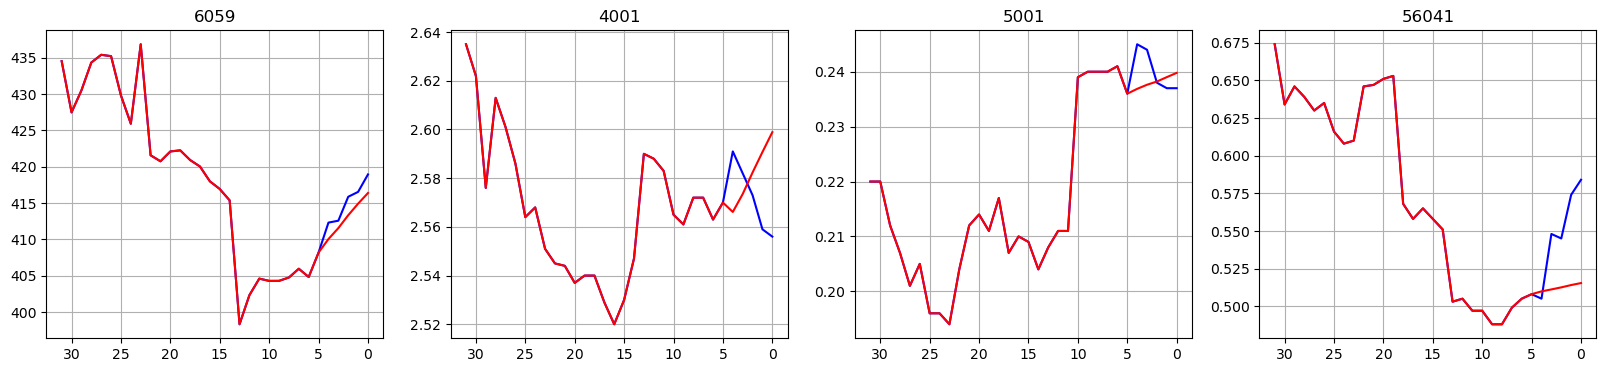

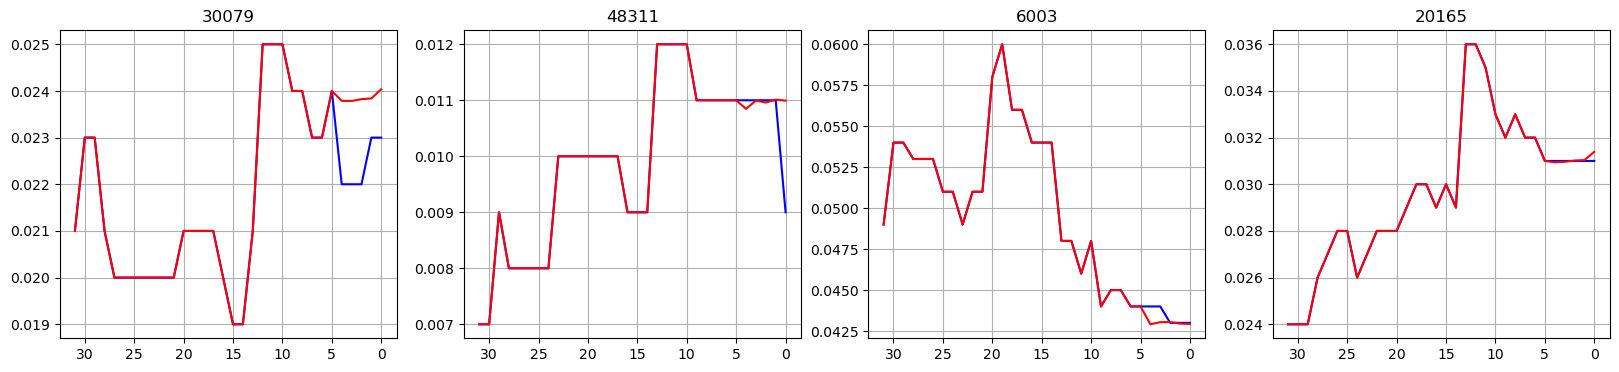

In [62]:
plot_preds(train_preds, eval_train_df, [6059, 4001, 5001, 56041])
plot_preds(train_preds, eval_train_df, [30079, 48311, 6003, 20165])

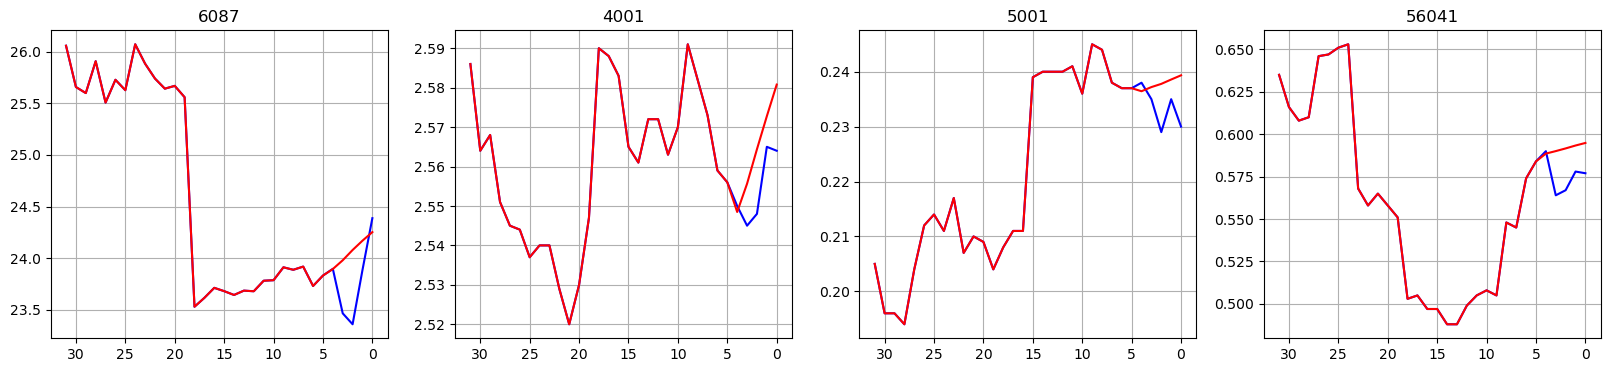

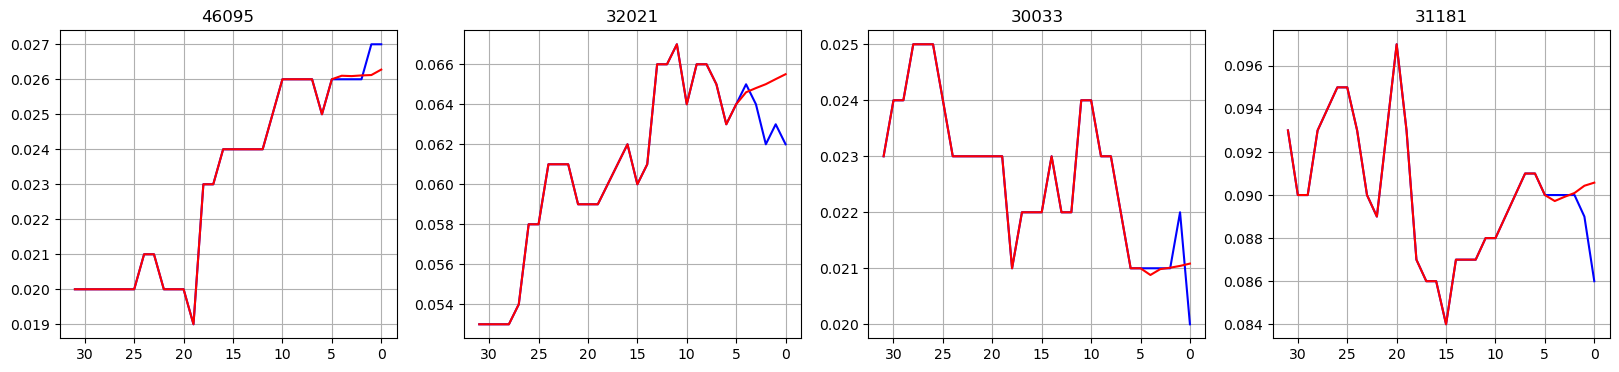

In [63]:
plot_preds(val_preds, eval_val_df, [6087, 4001, 5001, 56041])
plot_preds(val_preds, eval_val_df, [46095, 32021, 30033, 31181])

[47029, 47147, 45047, 6001]


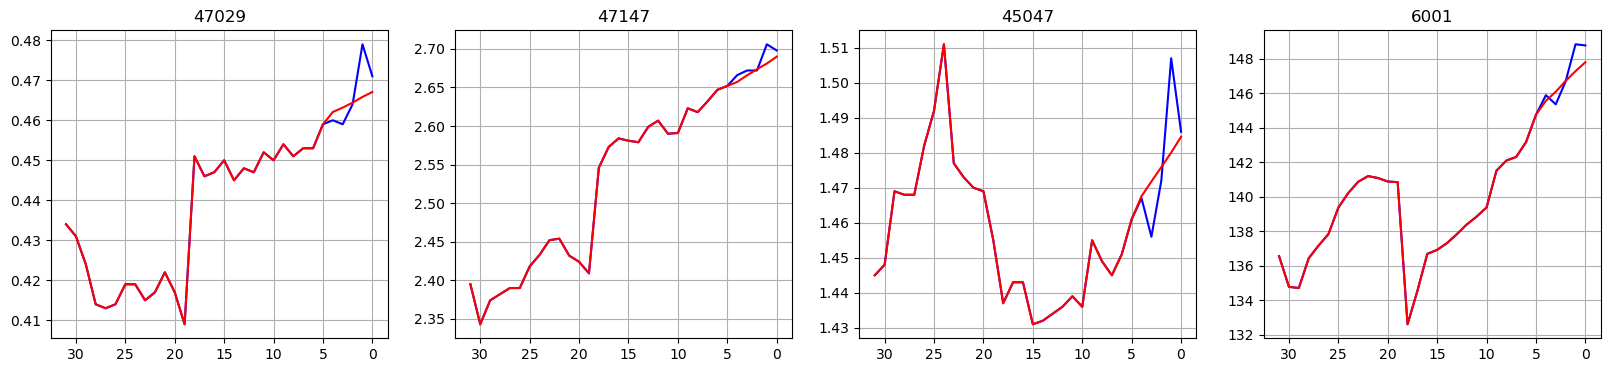

In [64]:
random_cfips = np.array(val_df.cfips.unique())
random_cfips = random_cfips[np.random.randint(0, len(random_cfips), size=4)]
print(random_cfips.tolist())
plot_preds(val_preds, eval_val_df, random_cfips.tolist())
# plot_preds(train_preds, train_df, [1001, 4001, 5001, 56041])